## The data grabbed from UHF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from loop antennas.

In [13]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd


sps = 10e6 # 10 Msps

In [2]:
def multistation_plotrec(files):
    
    channels = [0,1,3]
    fig, (ax) = plt.subplots(figsize=(35, 20), nrows=len(channels)*len(files), sharex=True)
    title = None
    
    data = {f:{"filename": f} for f in files}
    print(data)
    
    mintime = None
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

                time = s2t(0)
                if not mintime:
                    mintime = time
                if mintime > time:
                    mintime = time
        except Exception as e:
            print("Vyjimka 1", e)


    print("Znam minimalni cas", mintime)
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)

                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
                print("zacatek", s2t(0))
                offset = -int(t2s(mintime))
                #print("offset", offset)

                if title is not None:
                    fig.suptitle(title)

                for i, ch in enumerate(channels):
                    i += len(channels)*j
                    #print(i)

                    pre_trigger_blocks = h['preTrigger']
                    post_trigger_blocks = h['postTrigger']

                    a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
                    b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
                    #print(a, b)

                    signal_samples = samples[a:b,ch]
                    #print(a, b, len(samples[:,0]))

                    axis_plotrec(ax[i], h, signal_samples, a+offset, b+offset, ticker, formatter, str("{}, channel: {}".format(filepath, ch)))
        except Exception as e:
            print("Vyjimka", e)
        print("Done", fn)

    return fig

# Pokus o autokorelaci 

['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80', '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80', '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']
{'/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80': {'filename': '/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80'}, '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80': {'filename': '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80'}, '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81': {'filename': '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81'}}
0 /storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80
1 /storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80
2 /storage/experiments/2022/0909_bourka_CAR1/parallella-

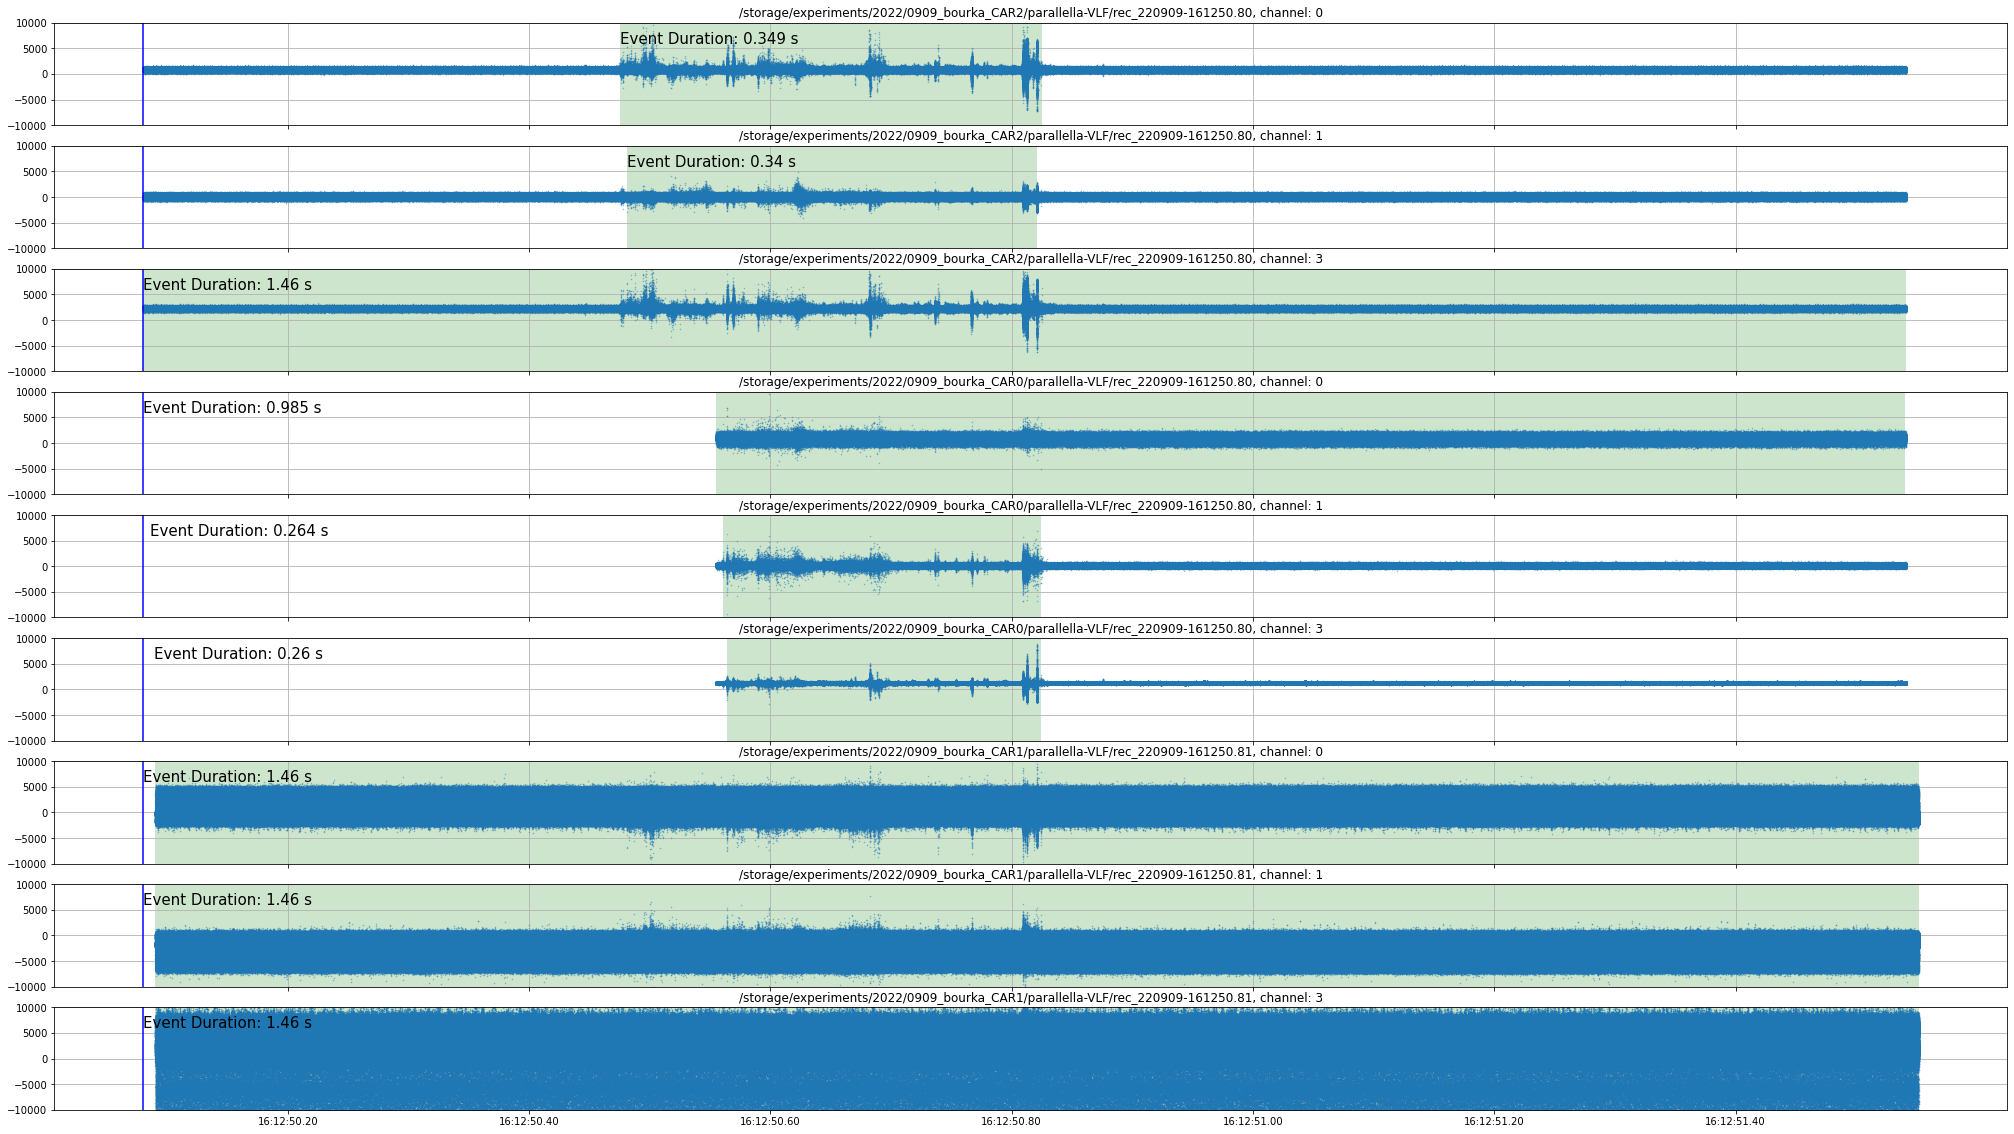

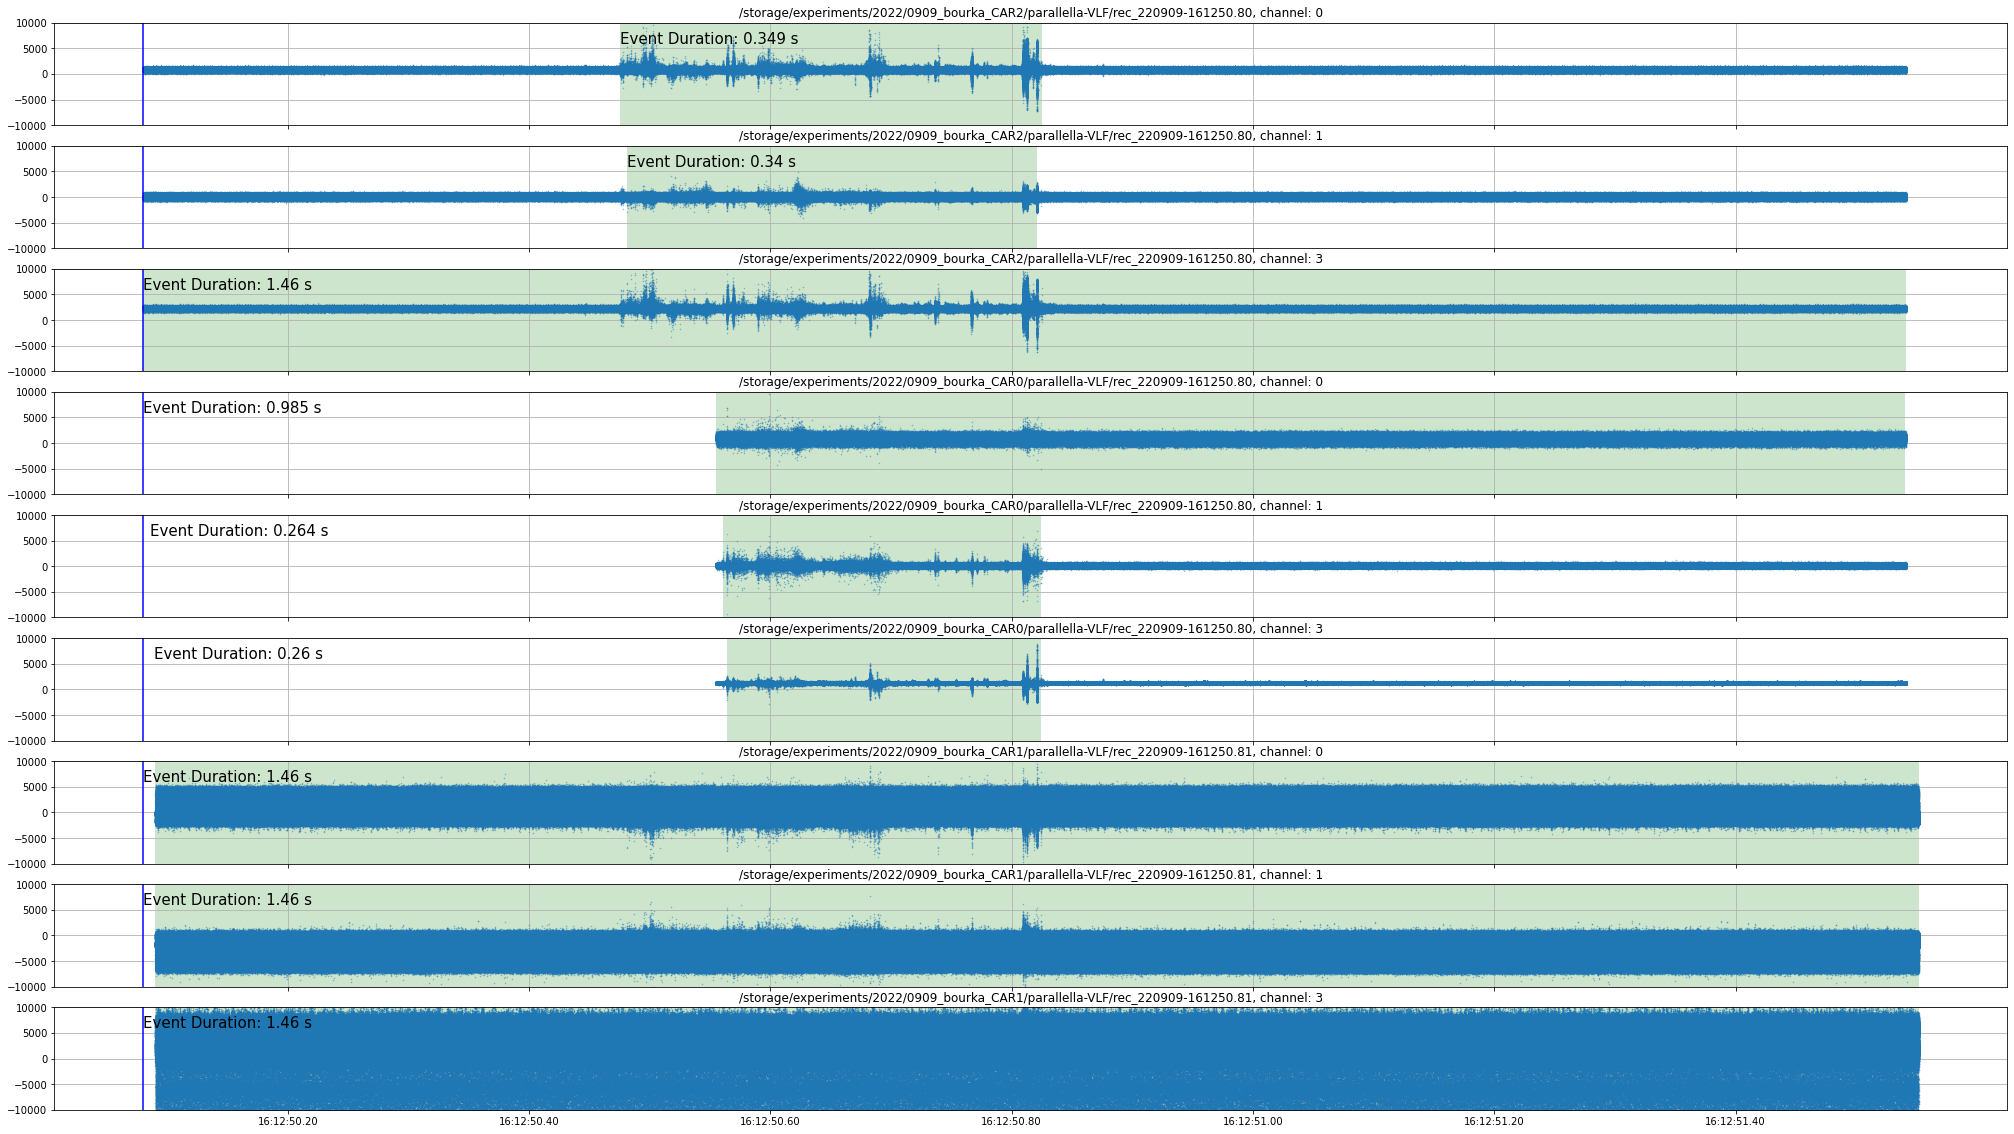

In [3]:
paths = ['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80','/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80', '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']
print(paths)

multistation_plotrec(paths)

Plot all lightning records (High memory and time consuming)

In [96]:
def extract_signal_fragment(files, date_str, start_time_str, end_time_str, selected_channels):
    fragments = []
    
    # Převod celého časového řetězce na objekty Timestamp
    start_datetime = pd.to_datetime(f'{date_str} {start_time_str}')
    end_datetime = pd.to_datetime(f'{date_str} {end_time_str}')

    for filepath in files:
        try:
            car_match = re.search(r'CAR(\d+)', filepath)
            if car_match:
                station_id = car_match.group(1)
            else:
                raise ValueError("Identifikátor stanice nebyl nalezen v cestě k souboru.")
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, _, _ = assign_time_axis(fn, h, synclog)

                # Získání indexů vzorků pro začátek a konec
                start_index = int(t2s(start_datetime))
                actual_start_index = max(start_index, 0)  # Korekce start_index, pokud je mimo rozsah
                end_index = min(int(t2s(end_datetime)), samples.shape[0])
                
                num_samples = end_index - start_index  # Počet vzorků v požadovaném okně
                
                if num_samples <= 0:
                    print(f"Časové okno '{start_datetime}' až '{end_datetime}' je mimo rozsah záznamu v souboru {filepath}.")
                    continue
                
                # Vytvoření fragmentu s doplněnými hodnotami na začátku, pokud je potřeba
                if start_index < 0:
                    padding_length = abs(start_index)
                    fragment = samples[0:end_index, :][:, selected_channels]
                    padding = np.zeros((padding_length, fragment.shape[1])).astype(np.int16)
                    fragment = np.vstack((padding, fragment))
                else:
                    fragment = samples[actual_start_index:end_index, :][:, selected_channels]
                
                # Doplnění nulami na konci, pokud fragment nemá požadovanou délku
                if fragment.shape[0] < num_samples:
                    padding_length = num_samples - fragment.shape[0]
                    padding = np.zeros((padding_length, samples.shape[1]))
                    fragment = np.vstack((fragment, padding))
                
                fragments.append(('CAR'+station_id+'_'+fn, fragment))
                
        except Exception as e:
            print(f"Chyba při zpracování souboru {filepath}: {e}")
    
    return fragments

In [139]:
date_str = "2022-09-09"
time_window_start = "16:12:50.45"  # Začátek extrakce
time_window_end = "16:12:50.85"    # Konec extrakce
selected_channels = [3]    #[0, 1, 3]
output_directory = "./test_data/"

files = ['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']

fragments = extract_signal_fragment(files, date_str, time_window_start, time_window_end, selected_channels)

for fn, fragment in fragments:
    # Uložení fragmentu do binárního souboru
    output_filename = f"{fn}_fragment.npy"
    output_path = os.path.join(output_directory, output_filename)
    np.save(output_path, fragment)
    print(f"Fragment uložen do {output_path}")
    print(f"Soubor: {fn}, Velikost fragmentu: {fragment.shape}, {fragment.dtype}")

Fragment uložen do ./test_data/CAR2_rec_220909-161250.80_fragment.npy
Soubor: CAR2_rec_220909-161250.80, Velikost fragmentu: (4000000, 1), int16
Fragment uložen do ./test_data/CAR0_rec_220909-161250.80_fragment.npy
Soubor: CAR0_rec_220909-161250.80, Velikost fragmentu: (4000000, 1), int16
Fragment uložen do ./test_data/CAR1_rec_220909-161250.81_fragment.npy
Soubor: CAR1_rec_220909-161250.81, Velikost fragmentu: (4000000, 1), int16


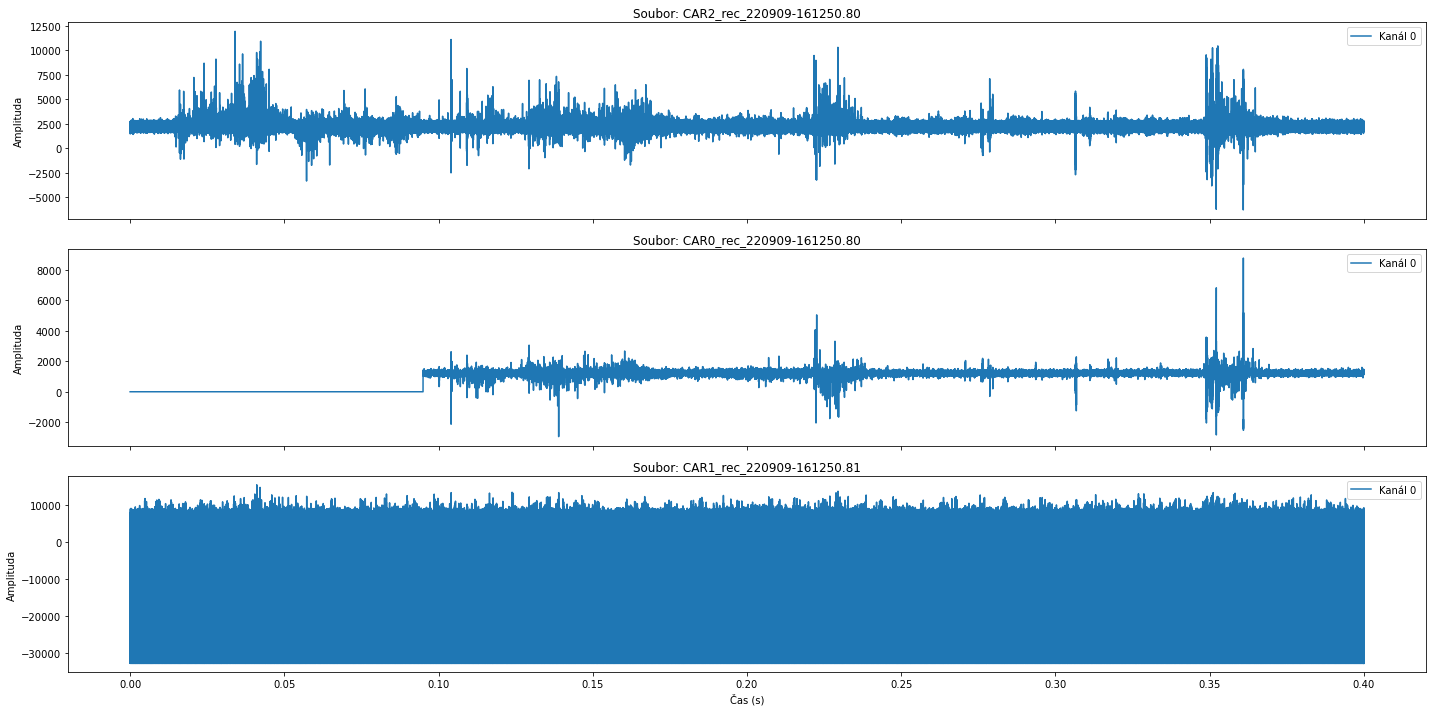

In [140]:
import matplotlib.pyplot as plt

def plot_fragments(fragments):
    num_fragments = len(fragments)
    fig, axs = plt.subplots(num_fragments, 1, figsize=(20, 10), sharex=True)

    if num_fragments == 1:  # Pokud je jen jeden fragment, axs není pole
        axs = [axs]

    for i, (filename, fragment) in enumerate(fragments):
        # Vytvoření časové osy (relativní, od 0)
        time_axis = np.linspace(0, fragment.shape[0]/sps, num=fragment.shape[0])

        # Vykreslení každého kanálu v fragmentu
        for ch in range(fragment.shape[1]):
            axs[i].plot(time_axis, fragment[:, ch], label=f'Kanál {ch}')
        
        axs[i].set_title(f'Soubor: {filename}')
        axs[i].set_ylabel('Amplituda')
        axs[i].legend(loc='upper right')

    axs[-1].set_xlabel('Čas (s)')
    plt.tight_layout()
    plt.show()

plot_fragments(fragments)


CAR2_rec_220909-161250.80: první 5 vzorků po korekci DC offsetu:
[[ -9.53868343]
 [-25.53868343]
 [-41.53868343]
 [ -9.53868343]
 [-41.53868343]]
CAR0_rec_220909-161250.80: první 5 vzorků po korekci DC offsetu:
[[-1067.61560686]
 [-1067.61560686]
 [-1067.61560686]
 [-1067.61560686]
 [-1067.61560686]]
CAR1_rec_220909-161250.81: první 5 vzorků po korekci DC offsetu:
[[ 170.73438629]
 [ 394.73438629]
 [ 234.73438629]
 [  58.73438629]
 [-213.26561371]]


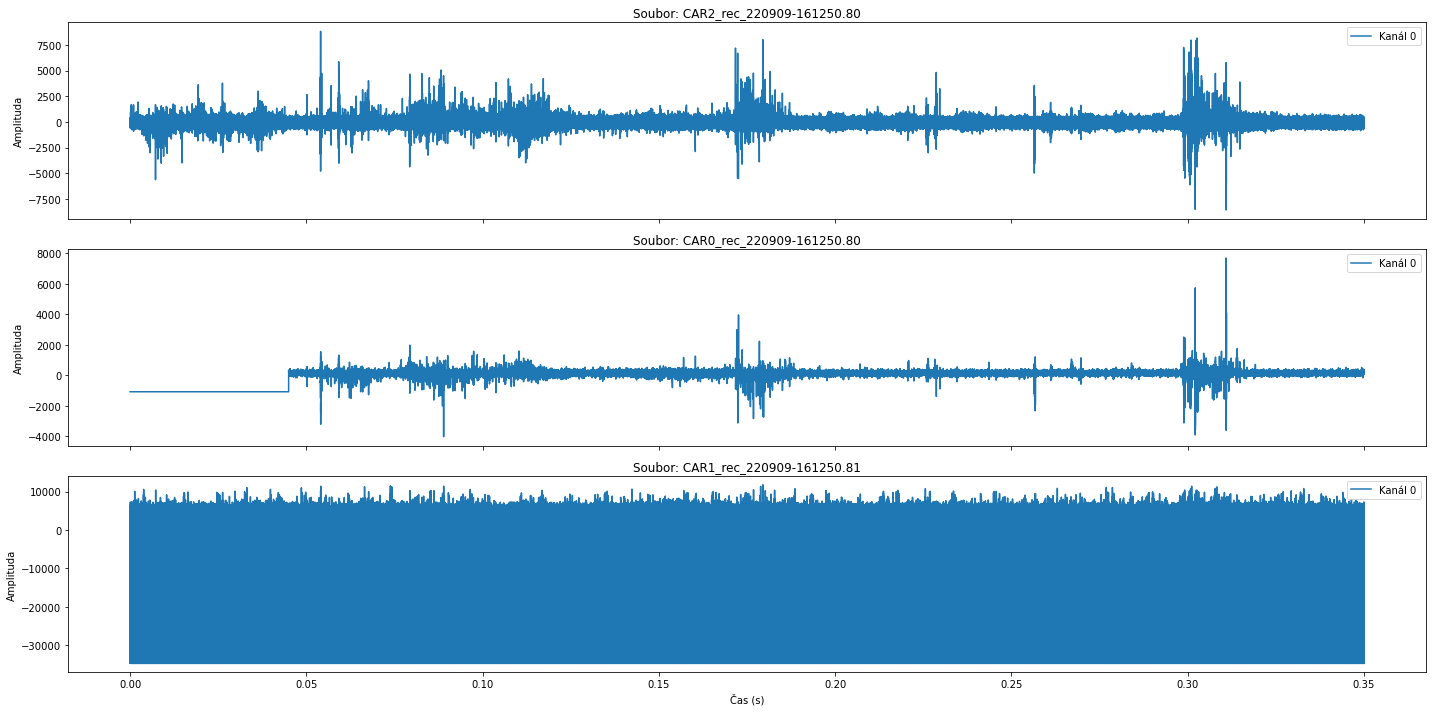

In [133]:
# Předpokládáme, že 'fragments' je váš seznam fragmentů signálů
corrected_fragments = []

for fn, fragment in fragments:
    # Výpočet průměru fragmentu
    fragment_mean = np.mean(fragment, axis=0)
    
    # Odečtení průměru od každého vzorku fragmentu
    corrected_fragment = fragment - fragment_mean
    
    # Uložení korigovaného fragmentu do seznamu
    corrected_fragments.append((fn, corrected_fragment))

# Výpis prvních několika hodnot korigovaného fragmentu pro kontrolu
for fn, corrected_fragment in corrected_fragments:
    print(f"{fn}: první 5 vzorků po korekci DC offsetu:\n{corrected_fragment[:5]}")
    
plot_fragments(corrected_fragments)

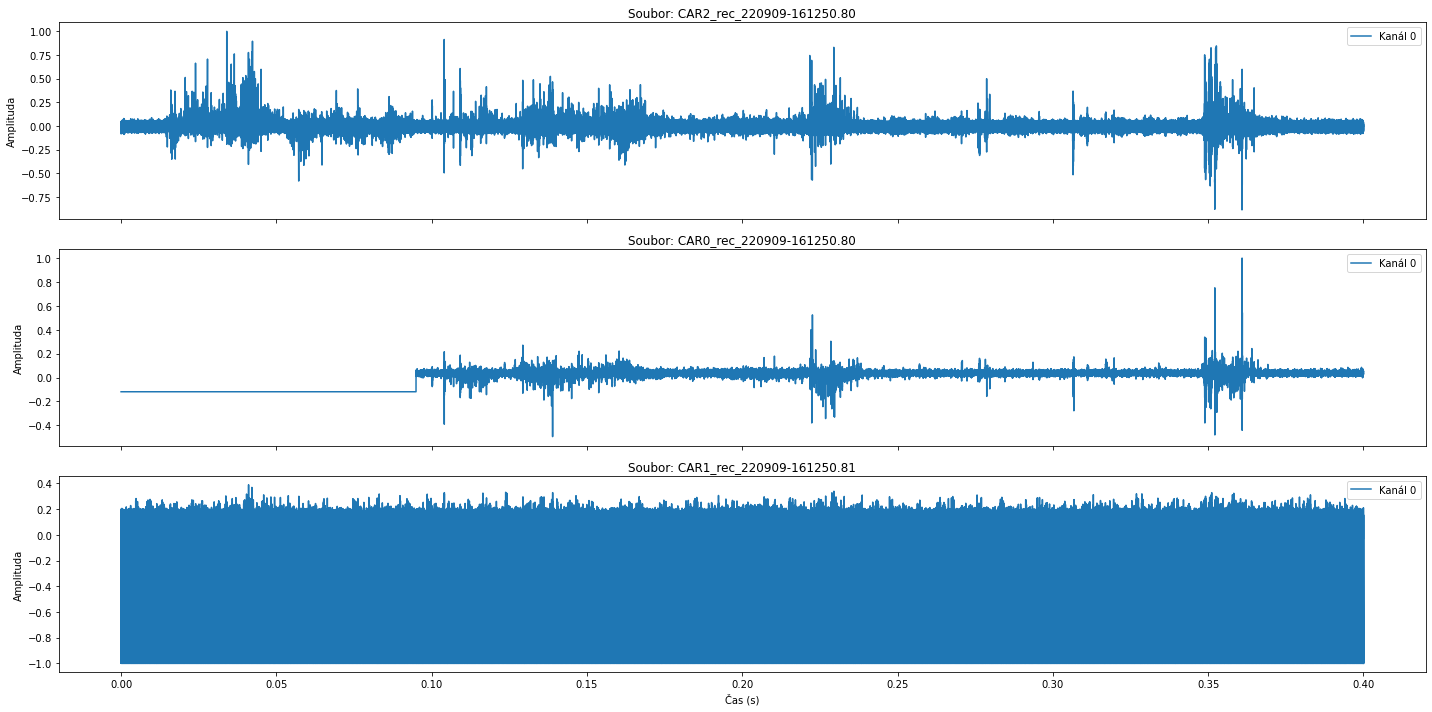

In [141]:
normalized_fragments = []

for fn, fragment in fragments:
    # Převedení na float pro zpracování
    fragment = fragment.astype(np.float32)
    
    # Odstranění DC offsetu (pokud ještě nebylo provedeno)
    fragment -= np.mean(fragment)
    
    # Normalizace na rozsah -1 až 1
    max_val = np.max(np.abs(fragment))
    if max_val > 0:  # Zabránění dělení nulou
        fragment /= max_val
    
    normalized_fragments.append((fn, fragment))

plot_fragments(normalized_fragments)

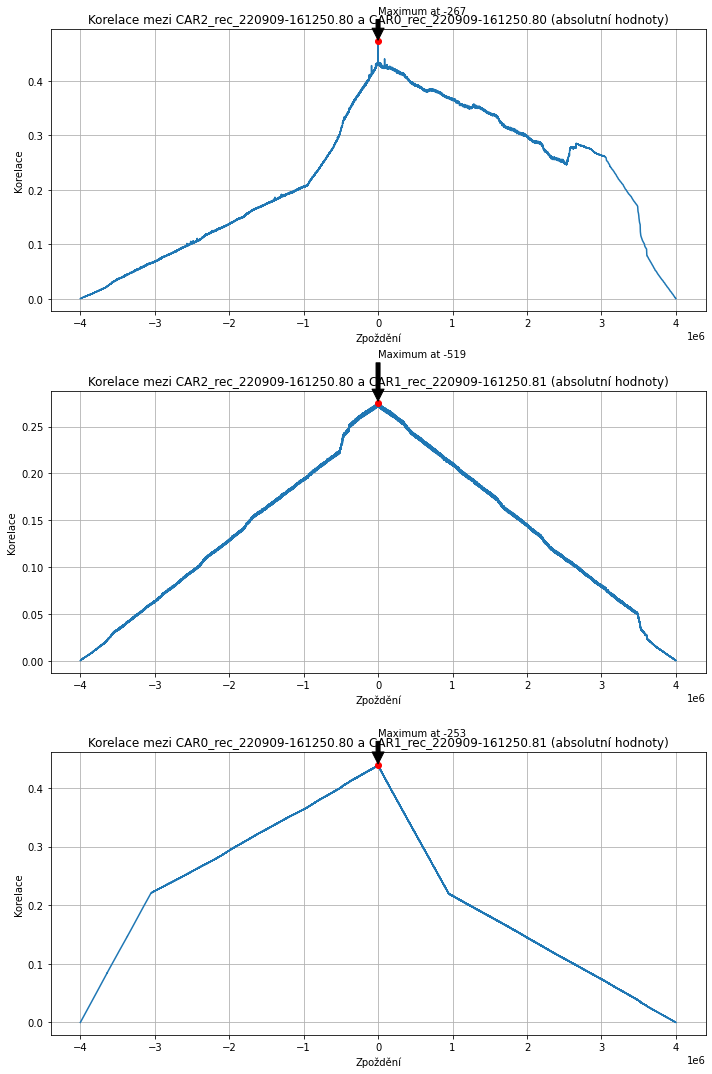

TDOA mezi CAR2_rec_220909-161250.80 a CAR0_rec_220909-161250.80: -0.000027 sekund, což odpovídá -8010.00 metrům
TDOA mezi CAR2_rec_220909-161250.80 a CAR1_rec_220909-161250.81: -0.000052 sekund, což odpovídá -15570.00 metrům
TDOA mezi CAR0_rec_220909-161250.80 a CAR1_rec_220909-161250.81: -0.000025 sekund, což odpovídá -7590.00 metrům


In [143]:
from itertools import combinations
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Příprava dat z normalized_fragments pro snazší manipulaci
data = {name: np.abs(fragment.flatten()) for name, fragment in normalized_fragments}

# Výpočet a vykreslení korelace mezi všemi páry signálů
fig, axs = plt.subplots(nrows=len(data)*(len(data)-1)//2, ncols=1, figsize=(10, 15))
axs_idx = 0

# Uložení výsledků TDOA pro výpis
tdoa_results = []

for (name1, signal1), (name2, signal2) in combinations(data.items(), 2):
    # Výpočet normalizované korelace
    corr = correlate(signal1, signal2, mode='full', method='auto')
    corr /= np.sqrt(np.dot(signal1, signal1) * np.dot(signal2, signal2))
    lags = np.arange(-len(signal1)+1, len(signal2))
    
    # Vykreslení korelace
    axs[axs_idx].plot(lags, corr)
    axs[axs_idx].set_title(f'Korelace mezi {name1} a {name2} (absolutní hodnoty)')
    axs[axs_idx].set_xlabel('Zpoždění')
    axs[axs_idx].set_ylabel('Korelace')
    axs[axs_idx].grid(True)
    
    # Zvýraznění maxima
    max_lag = lags[np.argmax(corr)]
    axs[axs_idx].plot(max_lag, np.max(corr), 'ro')  # Vrchol korelace
    axs[axs_idx].annotate(f'Maximum at {max_lag}', xy=(max_lag, np.max(corr)),
                          xytext=(max_lag, np.max(corr)+0.05),
                          arrowprops=dict(facecolor='black', shrink=0.05))
    
    axs_idx += 1
    # Výpočet TDOA a přidání do seznamu pro výpis
    tdoa = max_lag / sps
    tdoa_results.append(((name1, name2), tdoa))

plt.tight_layout()
plt.show()

# Výpis výsledků TDOA
for pair, tdoa in tdoa_results:
    # Přepočet TDOA na vzdálenost
    distance = tdoa * 3e8  # Přepočet na metry pomocí rychlosti světla ve vakuu
    print(f"TDOA mezi {pair[0]} a {pair[1]}: {tdoa:.6f} sekund, což odpovídá {distance:.2f} metrům")


In [148]:
import pynmea2
log_file_path = '/storage/experiments/2022/0909_bourka_CAR2/gps/base_gps_CAR2_20220909_105954.log'
def extract_coordinates_from_nmea(log_file_path):
    coordinates = []
    with open(log_file_path, 'r') as file:
        for line in file:
            try:
                # Pokus o dekódování každého řádku, ignorování chyb
                line = line.decode('utf-8', errors='ignore')
                if line.startswith('$GNGGA') or line.startswith('$GPGGA'):
                    msg = pynmea2.parse(line)
                    coordinates.append((msg.latitude, msg.longitude))
            except UnicodeDecodeError:
                continue  # Ignorování řádků, které nelze dekódovat
            except pynmea2.ParseError:
                continue  # Ignorování řádků, které nelze správně naparsovat
    return coordinates


ModuleNotFoundError: No module named 'pynmea2'

In [ ]:
parse_nmea_log()
